## Import

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree
import scipy
import awkward
import numpy as np
import time
import math

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/run3_muon_system_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi, drawCMS
import CMS_lumi, tdrstyle

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

Welcome to JupyROOT 6.24/06


## Load ntuples

## Load variables

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = ['v4','v5']
plot_folder = "v4_vs_v5"
vers = ['v5','v6']
plot_folder = "v5_vs_v6"
vers = ['v4','v5','v6','v10']
plot_folder = "v4_vs_v5_vs_v6_vs_v10"
#v1 includes events without selections
#v3 includes events with at least 2 clusters
#v4: no event level cuts, clusters made with DBSCAN, HLT time definition
#v5: no event level cuts, clusters made with CA
#v6: no event level cuts, clusters made with CA and R parameter 0.6

data_path = {}
data_label = {}
marker_style = {}
line_style = {}
colors = {}
data_label['datav4'] = 'DBSCAN data'
data_label['datav5'] = 'CA data 0.4'
data_label['datav6'] = 'CA data 0.6'
data_label['datav10'] = 'CA data 0.4, merging 0.6'

data_label['signalv4'] = 'DBSCAN signal'
data_label['signalv5'] = 'CA signal 0.4'
data_label['signalv6'] = 'CA signal 0.6'
data_label['signalv10'] = 'CA signal 0.4, merging 0.6'

marker_style['datav4'] = 22
marker_style['datav5'] = 24
marker_style['datav6'] = 25
marker_style['datav10'] = 20

marker_style['signalv4'] = 20
marker_style['signalv5'] = 20
marker_style['signalv6'] = 20
marker_style['signalv10'] = 20

line_style['datav4'] = 1
line_style['datav5'] = 1
line_style['datav6'] = 1
line_style['datav10'] = 1

line_style['signalv4'] = 1
line_style['signalv5'] = 2
line_style['signalv6'] = 3
line_style['signalv10'] = 1

colors['datav4'] = 1
colors['datav5'] = 2
colors['datav6'] = 4
colors['datav10'] = 800

colors['signalv4'] = 1#6
colors['signalv5'] = 2#8
colors['signalv6'] = 4#9
colors['signalv10'] = 800#805


for ve in vers:
    data_path[ve] = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+ve+'/'
lumi = 23.02*1000

if data_year == 2022:
    for ve in vers:
        fpath['data'+ve] = data_path[ve] + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
        fpath['signal'+ve] = data_path[ve] + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'

NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    print(k)
    print("Events: ", NEvents[k])
    
for k, T in tree.items():
    branch_names = T.keys()

datav4
Events:  15508012.0
signalv4
Events:  42882900.0
datav5
Events:  15508012.0
signalv5
Events:  42882668.0
datav6
Events:  15508012.0
signalv6
Events:  42882900.0
datav10
Events:  15508012.0
signalv10
Events:  42882900.0


In [3]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50


intime = True
DPHI_CUT = 1

gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#Trigger paths
HLT_CscCluster_Loose = {}
HLT_CscCluster_Medium = {}
HLT_CscCluster_Tight = {}
HLT_L1CSCShower_DTCluster50 = {}
HLT_L1CSCShower_DTCluster75 = {}


#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpreadWeighted = {}
cscClusterTimeSpread = {}
cscClusterTimeWeighted = {}
cscClusterTimeWeighted2 = {}
cscClusterTimeWeighted3 = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterR = {}
cscClusterZ = {}


cscClusterNStation = {}
cscClusterMaxChamber = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}

cscClusterNHitMinus13 = {}
cscClusterNHitMinus21 = {}
cscClusterNHitMinus22 = {}
cscClusterNHitMinus31 = {}
cscClusterNHitMinus32 = {}
cscClusterNHitMinus41 = {}
cscClusterNHitMinus42 = {}
cscClusterNHitPlus13 = {}
cscClusterNHitPlus21 = {}
cscClusterNHitPlus22 = {}
cscClusterNHitPlus31 = {}
cscClusterNHitPlus32 = {}
cscClusterNHitPlus41 = {}
cscClusterNHitPlus42 = {}
cscClusterNHit13 = {}
cscClusterNHit21 = {}
cscClusterNHit22 = {}
cscClusterNHit31 = {}
cscClusterNHit32 = {}
cscClusterNHit41 = {}
cscClusterNHit42 = {}



cscClusterDphi = {}
nCscClusters = {}

#Study trigger categories:
cscClusterTimeWeightedTr1 = {}
cscClusterTimeWeightedTr2 = {}
cscClusterTimeWeightedTr3 = {}
cscClusterTimeTr1 = {}
cscClusterTimeTr2 = {}
cscClusterTimeTr3 = {}
cscClusterEtaTr1 = {}
cscClusterEtaTr2 = {}
cscClusterEtaTr3 = {}
cscClusterNStationTr1 = {}
cscClusterNStationTr2 = {}
cscClusterNStationTr3 = {}
cscClusterSizeTr1 = {}
cscClusterSizeTr2 = {}
cscClusterSizeTr3 = {}

#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
nDtClusters = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}


## Settings

I want to decide the category after having filled the vectors

In [4]:
do_jet_veto = False
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = False
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = False
do_csc_in_time_cut = False
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True



In [5]:
for k, T in tree.items():
    
    tree_keys.append(k)
    print(k)
    #if not k == 'data' and not k[-4:] == '1000':continue
    
########### SELECTION: CLUSTERS ############

    #CSC
    
    jet_veto_csc = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30
    muon_veto_csc = np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal')))
    
    sel_csccluster = T.array('cscRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, jet_veto_csc)
    if do_inverted_jet_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(jet_veto_csc))      

    if do_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, muon_veto_csc)
    if do_inverted_muon_veto:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(muon_veto_csc))    

    #ME11 and ME12 veto
    ME11_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')==0
    )  

    ME12_veto = np.logical_and(
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12')==0  ,
        T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12')==0
    )
    
    if do_ME_veto:
        sel_csccluster = np.logical_and(sel_csccluster,
                                    np.logical_and(ME11_veto,ME12_veto)
                                   )           

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)

    #Missing branch:
    #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)

    #Time spread cut
    if do_csc_time_spread_cut:
        sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20)
    
    #Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, 
            T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))

    
    #DT

    jet_veto_dt = np.abs(T.array('dtRechitClusterJetVetoPt')) < 50
    muon_veto_dt = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    
    sel_dtcluster = T.array('dtRechitClusterSize') >= 0
    
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt)

    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt)    
    
    
    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1

        
    MB1_veto = T.array('dtRechitClusterNHitStation1') == 0
    
    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto)                                                                 

    #Missing branch:
    #sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1
    
    '''
    sel_dtcluster = np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId')))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    cut = 5
    station = (T.array('dtRechitClusterNSegStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegStation1'), T.array('dtRechitClusterNSegStation2')), T.array('dtRechitClusterNSegStation3')), T.array('dtRechitClusterNSegStation4'))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) 
    '''
   
    
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()    
    #HLT_CaloMET60_DTCluster50 = hlt[:,562]
    #HLT_CaloMET60_DTClusterNoMB1S50 = hlt[:,563]
    #HLT_L1MET_DTCluster50 = hlt[:,564]
    #HLT_L1MET_DTClusterNoMB1S50 = hlt[:,565]
    HLT_CscCluster_Loose[k] = hlt[:,566]
    HLT_CscCluster_Medium[k] = hlt[:,567]
    HLT_CscCluster_Tight[k] = hlt[:,568]
    HLT_L1CSCShower_DTCluster50[k] = hlt[:,569]
    HLT_L1CSCShower_DTCluster75[k] = hlt[:,570]

    #Or of the triggers: to reduce the size
    hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose[k],np.logical_or(HLT_CscCluster_Medium[k],HLT_CscCluster_Tight[k]))
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster50[k])
    hlt_sel_ev[k] = np.logical_or(hlt_sel_ev[k],HLT_L1CSCShower_DTCluster75[k])

    #sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
    #sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    #sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = T.array('nLeptons') == 0
    
    #OR of all the HLT paths:
    sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])

    #At least one csc cluster, always required
    sel_ev[k] = np.logical_and(sel_ev[k],sel_csccluster.sum()>=1)
    
    #Data runs with the triggers switched on
    if 'data' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('runNum')>=360019)
    

    #Categories later!
    '''
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
        #Adding this to avoid overlaps as a starting point
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == -1:      
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k]) 
    '''
    
########### BRANCHES ############

    #DT

    dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterTime[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,:]
    dtClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,:]
    
    #CSC
    
    cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]
    #cscClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'Time')[sel_csccluster][sel_ev[k]][:,:]
    #cscClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxChamber[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterMaxStation[k] =  T.array('cscRechitCluster' + cluster_index + 'MaxStation')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterR[k] = np.sqrt(  T.array('cscRechitCluster' + cluster_index + 'X')[sel_csccluster][sel_ev[k]][:,:]**2 + T.array('cscRechitCluster' + cluster_index + 'Y')[sel_csccluster][sel_ev[k]][:,:]**2 )
    cscClusterZ[k] = T.array('cscRechitCluster' + cluster_index + 'Z')[sel_csccluster][sel_ev[k]][:,:]    
    
    
    cscClusterNHitMinus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitMinus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus42')[sel_csccluster][sel_ev[k]][:,:]

    cscClusterNHitPlus13[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus13')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus21[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus21')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus22[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus22')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus31[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus31')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus32[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus32')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus41[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus41')[sel_csccluster][sel_ev[k]][:,:]
    cscClusterNHitPlus42[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus42')[sel_csccluster][sel_ev[k]][:,:]
    
    #Global
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    nDtClusters[k] = sel_dtcluster.sum()[sel_ev[k]]
               
    sel_jetveto_csc[k] = jet_veto_csc[sel_csccluster][sel_ev[k]][:,:]
    sel_muonveto_csc[k] = muon_veto_csc[sel_csccluster][sel_ev[k]][:,:]
        
    #This gives some errors...
    #nMe11[k] = T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11')[sel_csccluster][sel_ev[k]][:,0]+T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11')[sel_csccluster][sel_ev[k]][:,0]

    #To be fixed, some issues with deltaPhi function
    #deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
    #deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]
        


    nClusterRatio[k] = np.divide(nCscClusters[k].astype(float),nDtClusters[k].astype(float),out=np.zeros_like(nDtClusters[k].astype(float)),where=(nDtClusters[k].astype(float) != 0))

    #Reduce size
    HLT_CscCluster_Loose[k] = HLT_CscCluster_Loose[k][ sel_ev[k] ]
    HLT_CscCluster_Medium[k] = HLT_CscCluster_Medium[k][ sel_ev[k] ]
    HLT_CscCluster_Tight[k] = HLT_CscCluster_Tight[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster50[k] = HLT_L1CSCShower_DTCluster50[k][ sel_ev[k] ]
    HLT_L1CSCShower_DTCluster75[k] = HLT_L1CSCShower_DTCluster75[k][ sel_ev[k] ]
    
    hlt_sel_ev[k] = hlt_sel_ev[k][ sel_ev[k] ]
    sel_ev[k] = sel_ev[k][ sel_ev[k] ]
    print(sel_ev[k].shape)
    print(hlt_sel_ev[k].shape)
    print(HLT_CscCluster_Loose[k].shape)



datav4
(13316931,)
(13316931,)
(13316931,)
signalv4
(90554,)
(90554,)
(90554,)
datav5
(13624363,)
(13624363,)
(13624363,)
signalv5
(91218,)
(91218,)
(91218,)
datav6
(12135343,)
(12135343,)
(12135343,)
signalv6
(86995,)
(86995,)
(86995,)
datav10
(13503291,)
(13503291,)
(13503291,)
signalv10
(90893,)
(90893,)
(90893,)


In [6]:
tree_keys = list(dict.fromkeys(tree_keys))

print("Very loose selections")
for k in tree_keys:
    if "v4" in k: print("DBSCAN")
    if "v5" in k: print("CA 0.4")
    if "v6" in k: print("CA 0.6")
    print(k)
    print("==0 clusters ", (nCscClusters[k]==0).sum() )
    print("==1 cluster ", (nCscClusters[k]==1).sum() )
    print(">=1 cluster ", (nCscClusters[k]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k]==2).sum() )
    print(">=2 clusters ",  (nCscClusters[k]>=2).sum() )


Very loose selections
DBSCAN
datav4
==0 clusters  0
==1 cluster  13182774
>=1 cluster  13316931
==2 clusters  131967
>=2 clusters  134157
DBSCAN
signalv4
==0 clusters  0
==1 cluster  86881
>=1 cluster  90554
==2 clusters  3664
>=2 clusters  3673
CA 0.4
datav5
==0 clusters  0
==1 cluster  13250647
>=1 cluster  13624363
==2 clusters  362182
>=2 clusters  373716
CA 0.4
signalv5
==0 clusters  0
==1 cluster  86214
>=1 cluster  91218
==2 clusters  4848
>=2 clusters  5004
CA 0.6
datav6
==0 clusters  0
==1 cluster  12003284
>=1 cluster  12135343
==2 clusters  129241
>=2 clusters  132059
CA 0.6
signalv6
==0 clusters  0
==1 cluster  83631
>=1 cluster  86995
==2 clusters  3351
>=2 clusters  3364
datav10
==0 clusters  0
==1 cluster  13342192
>=1 cluster  13503291
==2 clusters  158370
>=2 clusters  161099
signalv10
==0 clusters  0
==1 cluster  87198
>=1 cluster  90893
==2 clusters  3680
>=2 clusters  3695


# Category and trigger preselections

In [98]:
category = 0#-1#0
category = 2
#-1: at least 1 csc
#0: exactly 1 csc
#1: exactly 2csc,
#2: 1csc+1dt,
#3: exactly 2 csc

plot_string = ""
#plot_string+= "_exactly_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto"
#plot_string+= "_at_least_1_csc_cluster_ME_veto"
#plot_string+= "_2_csc_clusters_ME_veto_csc_in_time_cut_time_spread_cut"
#plot_string+= "_at_least_1_csc_cluster_ME_veto_csc_in_time_cut_time_spread_cut"
#plot_string+= "_exactly_2_csc_clusters_ME_veto"
plot_string += "_csc_dt_cluster_ME_MB_veto"

category_m1_cut = {}
category_0_cut = {}
category_1_cut = {}
category_2_cut = {}


L1_plateau = {}
HLT_plateau = {}
TRG_plateau = {}
first_fired_HLT = {}
event_cut = {}

sel_trgCluster_tr1 ={}
sel_trgCluster_tr2 ={}
sel_trgCluster_tr3 ={}

first_fired_HLT = {} 
second_fired_HLT = {} 

first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}

first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}


sel_HLT_OR = {}

print(tree_keys)

for k in tree_keys:    
    print(k)
    #Event level
    L1_plateau[k] = ((cscClusterSize[k] >= 200).any()==True)

    if category==2:
        #do DT stuff
        event_cut[k] = np.logical_and(HLT_L1CSCShower_DTCluster50[k]==True,sel_ev[k])
        HLT_plateau[k] = (dtClusterSize[k] >=50).any()==True
    else:
        #do CSC stuff
        event_cut[k] = np.logical_and(HLT_CscCluster_Loose[k]==True,sel_ev[k])
        sel_trgCluster_tr1[k] = np.logical_and( cscClusterSize[k] >= 100, np.logical_and(cscClusterNStation[k]>=2, np.abs(cscClusterEta[k])<1.9))
        sel_trgCluster_tr2[k] = np.logical_and( cscClusterSize[k] >= 200, np.logical_and(cscClusterNStation[k]==1, np.abs(cscClusterEta[k])<1.9))   
        sel_trgCluster_tr3[k] = np.logical_and( cscClusterSize[k] >= 500, np.abs(cscClusterEta[k])>=1.9)

        sel_HLT_OR[k] = np.logical_or(sel_trgCluster_tr1[k],np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k]))
        HLT_plateau[k] = np.logical_or( sel_trgCluster_tr1[k] , np.logical_or(sel_trgCluster_tr2[k],sel_trgCluster_tr3[k])  ).any()==True
      
        
        
    TRG_plateau[k] = np.logical_and( L1_plateau[k], HLT_plateau[k])
    event_cut[k] = np.logical_and(TRG_plateau[k],event_cut[k])
    

    
    #Use the right variable to classify stuff here
    if category == 0:
        event_cut[k]  = np.logical_and(event_cut[k], nCscClusters[k]== 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 1:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 2)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
        #second_fired_HLT[k] = sel_HLT_OR[k][:,1]>0
    elif category == 2:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 1)
        event_cut[k]  = np.logical_and(event_cut[k],nDtClusters[k] == 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    elif category == 3:
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] == 2)
    elif category == -1:      
        event_cut[k]  = np.logical_and(event_cut[k],nCscClusters[k] >= 1)
        #first_fired_HLT[k] = sel_HLT_OR[k][:,0]>0
    
    #print(cscClusterR[k][event_cut[k]][:,0])
    first_in_ME11[k] = (cscClusterR[k][:,0]>100)&(cscClusterR[k][:,0]<275) &(abs(cscClusterZ[k][:,0])>580)&(abs(cscClusterZ[k][:,0])<632) 
    first_in_ME12[k] = (cscClusterR[k][:,0]>275)&(cscClusterR[k][:,0]<465) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)
    first_in_ME13[k] = (cscClusterR[k][:,0]>505)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>668)&(abs(cscClusterZ[k][:,0])<724)

    first_in_ME21[k] = (cscClusterR[k][:,0]>139)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>789)&(abs(cscClusterZ[k][:,0])<850)
    first_in_ME22[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>791)&(abs(cscClusterZ[k][:,0])<850)

    first_in_ME31[k] = (cscClusterR[k][:,0]>160)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>915)&(abs(cscClusterZ[k][:,0])<970)
    first_in_ME32[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>911)&(abs(cscClusterZ[k][:,0])<970)

    first_in_ME41[k] = (cscClusterR[k][:,0]>178)&(cscClusterR[k][:,0]<345) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    first_in_ME42[k] = (cscClusterR[k][:,0]>357)&(cscClusterR[k][:,0]<700) &(abs(cscClusterZ[k][:,0])>1002)&(abs(cscClusterZ[k][:,0])<1063)
    
    first_in_plateau_ME11[k] = first_in_ME11[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME21[k] = first_in_ME21[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME31[k] = first_in_ME31[k] & (cscClusterSize[k][:,0]>=500)
    first_in_plateau_ME41[k] = first_in_ME41[k] & (cscClusterSize[k][:,0]>=500)

    first_in_plateau_ME12[k] = first_in_ME12[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME13[k] = first_in_ME13[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME22[k] = (first_in_ME22[k]) & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME32[k] = first_in_ME32[k] & (cscClusterSize[k][:,0]>=200)
    first_in_plateau_ME42[k] = first_in_ME42[k] & (cscClusterSize[k][:,0]>=200)    
    
    first_in_plateau[k] = first_in_plateau_ME11[k] | first_in_plateau_ME12[k] | first_in_plateau_ME13[k] | first_in_plateau_ME21[k] | first_in_plateau_ME22[k] | first_in_plateau_ME31[k] | first_in_plateau_ME32[k] | first_in_plateau_ME41[k] | first_in_plateau_ME42[k]

    event_cut[k] = event_cut[k] & first_in_plateau[k]
    
    ###FIX: some sel HLT OR have zero entries, check why
    
    #print(HLT_plateau[k].shape)
    #print(sel_ev[k].shape)
    #print(cscClusterSize[k].shape)
    #print(nCscClusters[k])

['datav4', 'signalv4', 'datav5', 'signalv5', 'datav6', 'signalv6', 'datav10', 'signalv10']
datav4
signalv4
datav5
signalv5
datav6
signalv6
datav10
signalv10


Check when we get a dramatic difference in the number of events!!!

In [99]:
print("Category selections")
for k in tree_keys:
    #if "v4" in k: print("DBSCAN")
    #if "v5" in k: print("CA 0.4")
    #if "v6" in k: print("CA 0.6")
    print(k)
    print("==0 clusters ", (nCscClusters[k][event_cut[k]]==0).sum() )
    print("==1 cluster ", (nCscClusters[k][event_cut[k]]==1).sum() )
    #print(">=1 cluster ", (nCscClusters[k][event_cut[k]]>=1).sum() )
    print("==2 clusters ", (nCscClusters[k][event_cut[k]]==2).sum() )
    #print(">=2 clusters ",  (nCscClusters[k][event_cut[k]]>=2).sum() )

Category selections
datav4
==0 clusters  0
==1 cluster  14514
==2 clusters  0
signalv4
==0 clusters  0
==1 cluster  1629
==2 clusters  0
datav5
==0 clusters  0
==1 cluster  14466
==2 clusters  0
signalv5
==0 clusters  0
==1 cluster  1670
==2 clusters  0
datav6
==0 clusters  0
==1 cluster  7350
==2 clusters  0
signalv6
==0 clusters  0
==1 cluster  1518
==2 clusters  0
datav10
==0 clusters  0
==1 cluster  14248
==2 clusters  0
signalv10
==0 clusters  0
==1 cluster  1676
==2 clusters  0


## General histograms

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

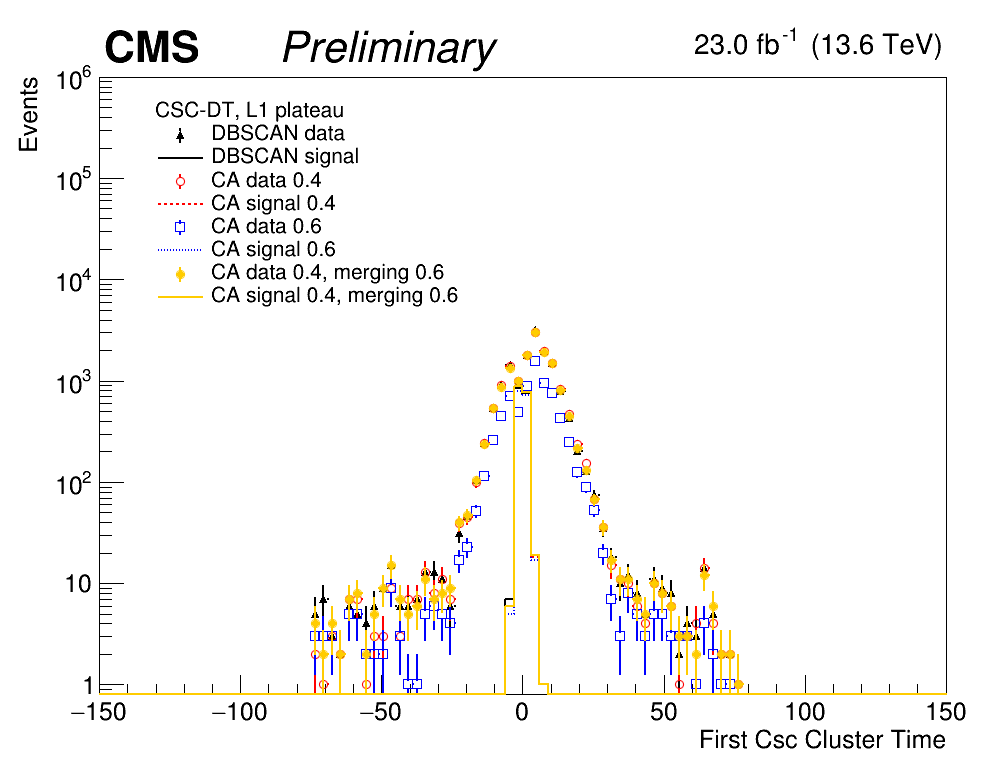

In [100]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5-0.35,0.6,0.75-0.35,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTime[:,0].flatten(),title="",axis_title = ['First Csc Cluster Time','Events'], binning=[100,-150,150])
    leg.AddEntry(h0[k],data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTime"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTime"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

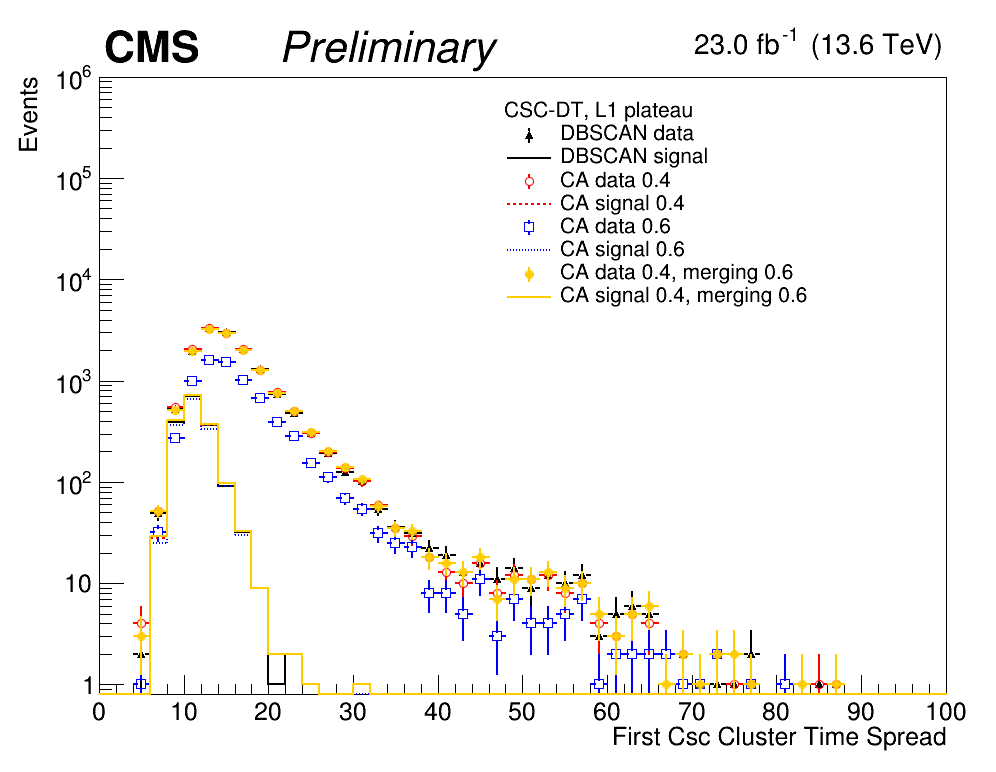

In [101]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    tmp_cscClusterTimeSpread = cscClusterTimeSpread[k][ event_cut[k] ]
    h0[k] = create_TH1D(tmp_cscClusterTimeSpread[:,0].flatten(),title="",axis_title = ['First Csc Cluster Time Spread','Events'], binning=[50,0,100])
    leg.AddEntry(h0[k],data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeSpread"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterTimeSpread"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

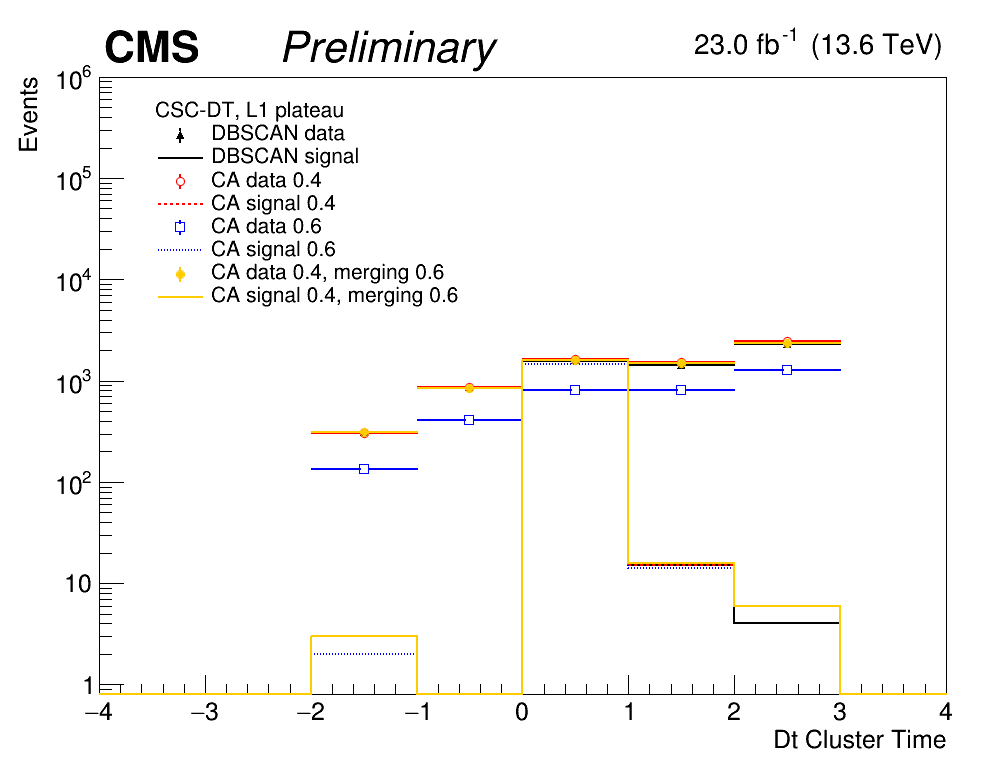

In [102]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5-0.35,0.6,0.75-0.35,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    #TODO: DT stuff
    if category==2:
        tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] ][:,0]
        h0[k] = create_TH1D(tmp_dtClusterTime.flatten(),title="",axis_title = ['Dt Cluster Time','Events'], binning=[8,-4,4])
    else:
        tmp_cscClusterTime = cscClusterTime[k][ event_cut[k] ][:,1]
        h0[k] = create_TH1D(tmp_cscClusterTime.flatten(),title="",axis_title = ['Second Csc Cluster Time','Events'], binning=[100,-150,150])
    leg.AddEntry(h0[k],data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterTime"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterTime"+plot_string+".png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DtSecondClusterTimeSpread_csc_dt_cluster_ME_MB_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DtSecondClusterTimeSpread_csc_dt_cluster_ME_MB_veto.png has been created


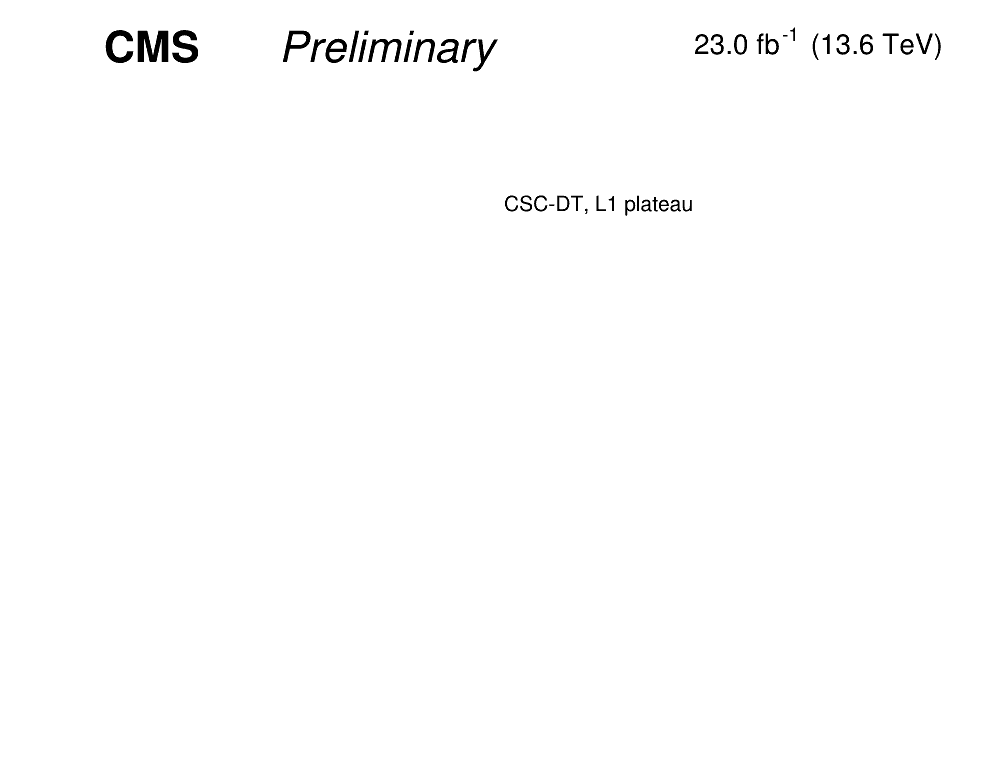

In [103]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
hoot = {}
hit = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    #TODO: DT stuff
    if category==2:
        continue
        #tmp_dtClusterTime = dtClusterTime[k][ event_cut[k] ][:,0]
        #h0[k] = create_TH1D(tmp_dtClusterTime.flatten(),title="",axis_title = ['Dt Cluster Time','Events'], binning=[8,-4,4])
    else:
        tmp_t = np.abs(cscClusterTime[k][ event_cut[k] ][:,1])
        tmp_cscClusterTimeSpread = cscClusterTimeSpread[k][ event_cut[k] ][:,1]
        h0[k] = create_TH1D(tmp_cscClusterTimeSpread.flatten(),title="",axis_title = ['Second Csc Cluster Time Spread','Events'], binning=[50,0,200])
        #hoot[k] = create_TH1D(tmp_cscClusterTimeSpread[tmp_t>50].flatten(),title="",axis_title = ['Second Csc Cluster Time Spread','Events'], binning=[50,0,200])
        #hit[k] = create_TH1D(tmp_cscClusterTimeSpread[tmp_t<50].flatten(),title="",axis_title = ['Second Csc Cluster Time Spread','Events'], binning=[50,0,200])
        
    leg.AddEntry(h0[k],data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterTimeSpread"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterTimeSpread"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

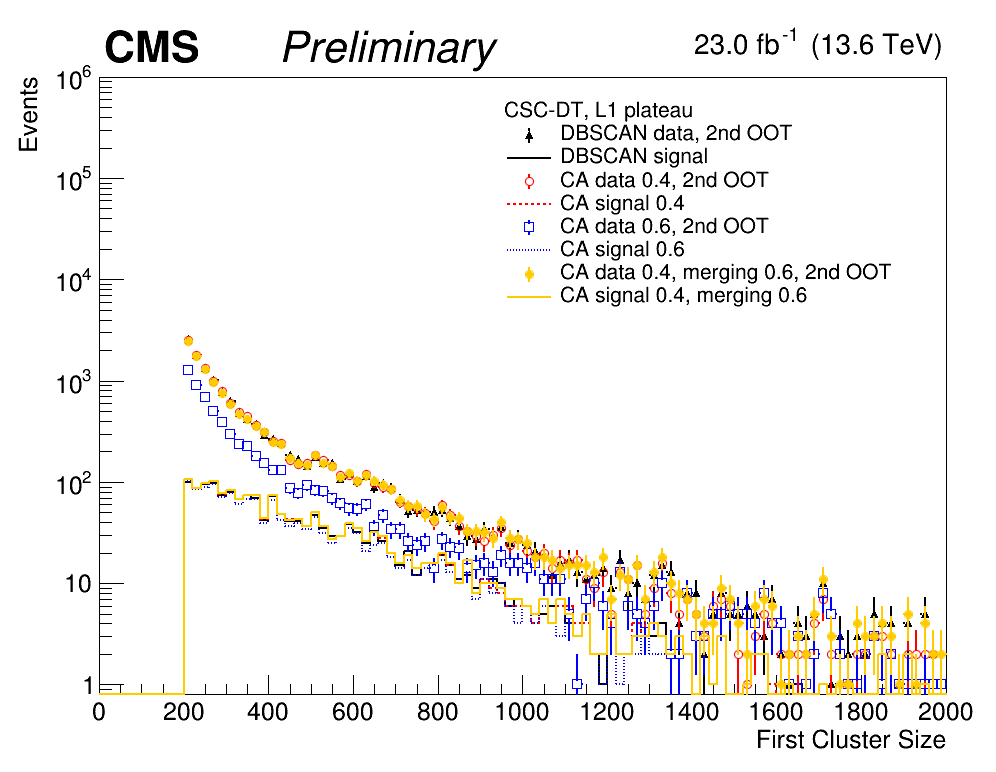

In [104]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
time_lab = ", 2nd OOT"#"BX!=0" if category==2 else "|t|>50 ns"
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    if category==2:
        tmp_ClusterSize = cscClusterSize[k][ event_cut[k]][:,0]
        tmp_ClusterTime = dtClusterTime[k][ event_cut[k]][:,0]
        tmp_blind = np.abs(tmp_ClusterTime)!=0 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
    else:
        tmp_ClusterSize = cscClusterSize[k][ event_cut[k]][:,0]
        tmp_ClusterTime = cscClusterTime[k][ event_cut[k]][:,1]
        tmp_blind = np.abs(tmp_ClusterTime)>50 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
    h0[k] = create_TH1D(tmp_ClusterSize[ tmp_blind ].flatten(),title="",axis_title = ['First Cluster Size','Events'], binning=[100,0,2000])
    if 'data' in k:
        leg.AddEntry(h0[k],data_label[k]+time_lab,'PE' if 'data' in k else 'L')
    else:
        leg.AddEntry(h0[k],data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_blinded"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/CscFirstClusterSize_blinded"+plot_string+".png")

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

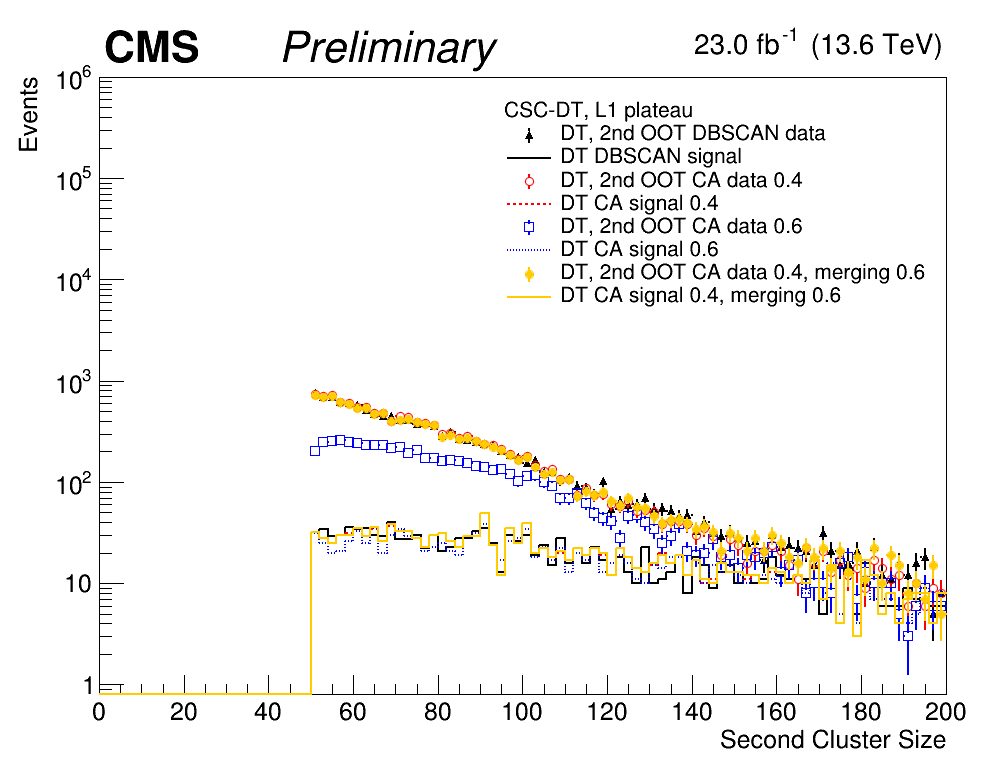

In [105]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.6,0.75,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
time_lab = ", 2nd OOT"#"BX!=0" if category==2 else "|t|>50 ns"
leg.SetHeader("CSC-"+phrase+", L1 plateau")

for k in tree_keys:
    if category==2:
        tmp_ClusterSize = dtClusterSize[k][ event_cut[k]][:,0]
        tmp_ClusterTime = dtClusterTime[k][ event_cut[k]][:,0]
        tmp_blind = np.abs(tmp_ClusterTime)!=0 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
    else:
        tmp_ClusterSize = cscClusterSize[k][ event_cut[k]][:,1]
        tmp_ClusterTime = cscClusterTime[k][ event_cut[k]][:,1]
        tmp_blind = np.abs(tmp_ClusterTime)>50 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
    h0[k] = create_TH1D(tmp_ClusterSize[ tmp_blind ].flatten(),title="",axis_title = ['Second Cluster Size','Events'], binning=[100,0,200])
    if 'data' in k:
        leg.AddEntry(h0[k],phrase+time_lab+" "+data_label[k],'PE' if 'data' in k else 'L')
    else:
        leg.AddEntry(h0[k],phrase+" "+data_label[k],'PE' if 'data' in k else 'L')
    h0[k].SetLineColor(colors[k])
    h0[k].SetLineWidth(2)
    h0[k].SetLineStyle(line_style[k])
    h0[k].SetMarkerColor(colors[k])
    h0[k].SetMarkerStyle(marker_style[k])
    h0[k].SetMarkerSize(1.2)
    #if h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

    h0[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h0[k].SetMinimum(0.8)
    h0[k].SetMaximum(1.e6)
    
leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)

# if setlog: 
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterSize_blinded"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/"+plot_name+"SecondClusterSize_blinded"+plot_string+".png")

# Delta Phi between first and second cluster

/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

DBSCAN: S 1629, B 14514, S/B 0.1122, S/sqrt(B) 13.52 
CA 0.6: S 1518, B 7350, S/B 0.2065, S/sqrt(B) 17.71 
CA 0.4: S 1670, B 14466, S/B 0.1154, S/sqrt(B) 13.88 
CA 0.4 merging 0.6: S 1676, B 14248, S/B 0.1176, S/sqrt(B) 14.04 
DT size > 100
DBSCAN: S 889, B 3145, S/B 0.2827, S/sqrt(B) 15.85 
CA 0.6: S 843, B 1998, S/B 0.4219, S/sqrt(B) 18.86 
CA 0.4: S 913, B 2788, S/B 0.3275, S/sqrt(B) 17.29 
CA 0.4 merging 0.6: S 917, B 2897, S/B 0.3165, S/sqrt(B) 17.04 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: pdf file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DeltaPhi_clusters_csc_dt_cluster_ME_MB_veto.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v4_vs_v5_vs_v6_vs_v10/DeltaPhi_clusters_csc_dt_cluster_ME_MB_veto.png has been created


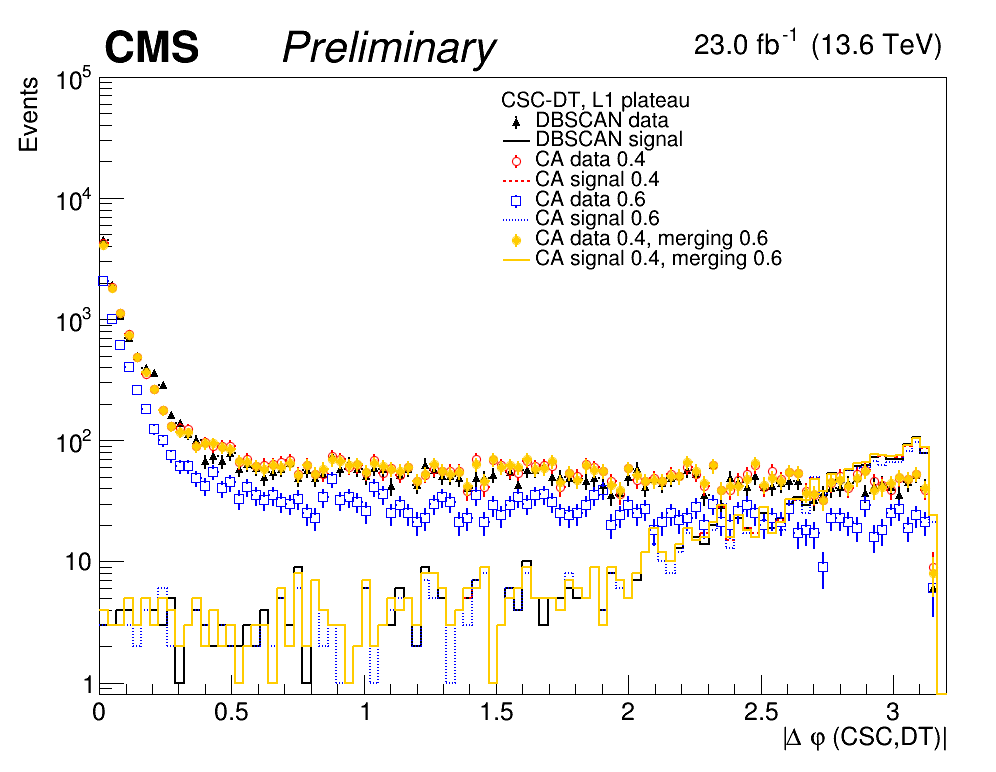

In [108]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.65,0.65,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

nevents_passing = {}
nevents_passing_80 = {}

for k in tree_keys:
    
    tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] ][:,0]
    tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] ][:,0]
    if category==2:
        tmp_eta_2 = dtClusterEta[k][ event_cut[k] ][:,0]
        tmp_phi_2 = dtClusterPhi[k][ event_cut[k] ][:,0]
        tmp_size_2 = dtClusterSize[k][ event_cut[k] ][:,0]
    else:
        tmp_eta_2 = cscClusterEta[k][ event_cut[k] ][:,1]
        tmp_phi_2 = cscClusterPhi[k][ event_cut[k] ][:,1]
        tmp_size_2 = cscClusterSize[k][ event_cut[k] ][:,1]
        
    tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_phi_2.flatten()))

    
    h1[k] = create_TH1D(tmp_dPhi,title="",axis_title = ['|#Delta #varphi (CSC,'+phrase+')|','Events'], binning=[100,0,3.2])
    leg.AddEntry(h1[k],data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].SetMaximum(1.e05)
    h1[k].SetMinimum(0.8)

    nevents_passing[k] = event_cut[k][ event_cut[k] ].sum()
    nevents_passing_80[k] = event_cut[k][ event_cut[k]][ tmp_size_2>100 ].sum()
    
leg.Draw()
can.SetRightMargin(0.05)

print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv4'], nevents_passing['datav4'], float(nevents_passing['signalv4'])/float(nevents_passing['datav4']), float(nevents_passing['signalv4'])/float(math.sqrt(nevents_passing['datav4'])) ) )
print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv6'], nevents_passing['datav6'], float(nevents_passing['signalv6'])/float(nevents_passing['datav6']), float(nevents_passing['signalv6'])/float(math.sqrt(nevents_passing['datav6'])) ) )
print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv5'], nevents_passing['datav5'], float(nevents_passing['signalv5'])/float(nevents_passing['datav5']), float(nevents_passing['signalv5'])/float(math.sqrt(nevents_passing['datav5'])) ) )
print("CA 0.4 merging 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv10'], nevents_passing['datav10'], float(nevents_passing['signalv10'])/float(nevents_passing['datav10']), float(nevents_passing['signalv10'])/float(math.sqrt(nevents_passing['datav10'])) ) )

if category==2:
    print("DT size > 100")
    print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv4'], nevents_passing_80['datav4'], float(nevents_passing_80['signalv4'])/float(nevents_passing_80['datav4']), float(nevents_passing_80['signalv4'])/float(math.sqrt(nevents_passing_80['datav4'])) ) )
    print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv6'], nevents_passing_80['datav6'], float(nevents_passing_80['signalv6'])/float(nevents_passing_80['datav6']), float(nevents_passing_80['signalv6'])/float(math.sqrt(nevents_passing_80['datav6'])) ) )
    print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv5'], nevents_passing_80['datav5'], float(nevents_passing_80['signalv5'])/float(nevents_passing_80['datav5']), float(nevents_passing_80['signalv5'])/float(math.sqrt(nevents_passing_80['datav5'])) ) )
    print("CA 0.4 merging 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv10'], nevents_passing_80['datav10'], float(nevents_passing_80['signalv10'])/float(nevents_passing_80['datav10']), float(nevents_passing_80['signalv10'])/float(math.sqrt(nevents_passing_80['datav10'])) ) )

# if setlog: 
can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_clusters"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_clusters"+plot_string+".png")
#can.Close()

datav4
signalv4
datav5
signalv5
datav6
signalv6
datav10
signalv10
DBSCAN: S 1629, B 12906, S/B 0.1262, S/sqrt(B) 14.34 
CA 0.6: S 1518, B 6545, S/B 0.2319, S/sqrt(B) 18.76 
CA 0.4: S 1670, B 12815, S/B 0.1303, S/sqrt(B) 14.75 
CA 0.4 merging 0.6: S 1676, B 12648, S/B 0.1325, S/sqrt(B) 14.90 
DT size > 100
DBSCAN: S 889, B 2713, S/B 0.3277, S/sqrt(B) 17.07 
CA 0.6: S 843, B 1761, S/B 0.4787, S/sqrt(B) 20.09 
CA 0.4: S 913, B 2399, S/B 0.3806, S/sqrt(B) 18.64 
CA 0.4 merging 0.6: S 917, B 2512, S/B 0.3650, S/sqrt(B) 18.30 


/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/run3/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spe

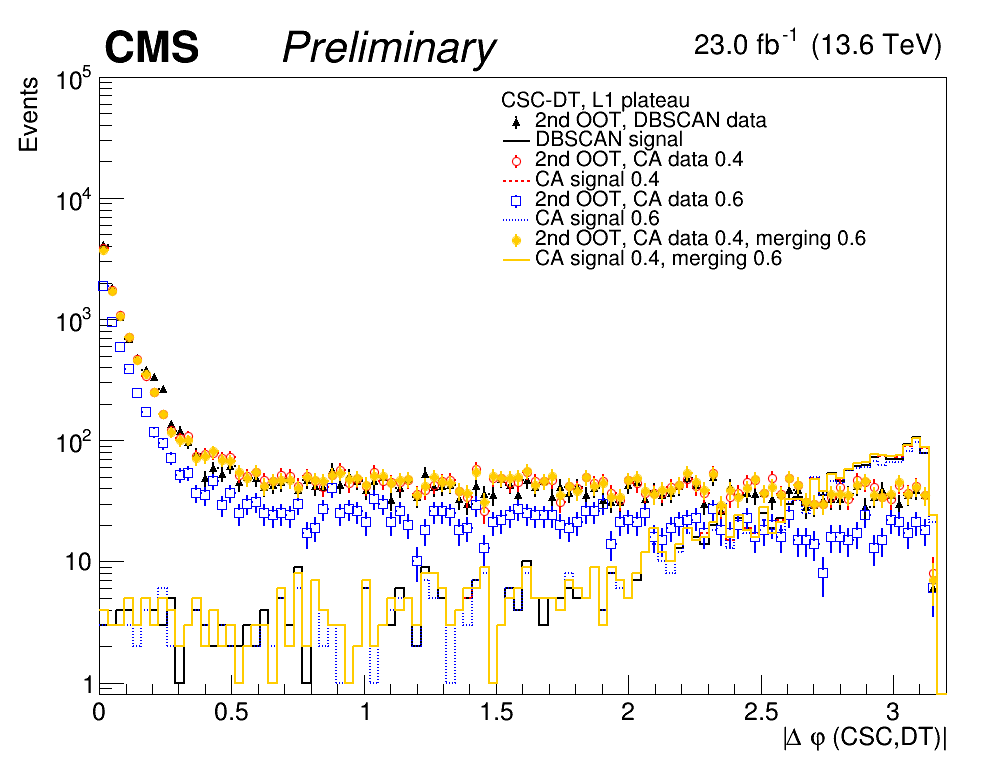

In [110]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.5,0.65,0.65,0.88)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
can.cd()
phrase = "DT" if category==2 else 'CSC'
plot_name = "Dt"  if category==2 else 'Csc'
leg.SetHeader("CSC-"+phrase+", L1 plateau")

nevents_passing = {}
nevents_passing_80 = {}

for k in tree_keys:
    print(k)

    tmp_cscClusterEta = cscClusterEta[k][ event_cut[k] ][:,0]
    tmp_cscClusterPhi = cscClusterPhi[k][ event_cut[k] ][:,0]
    if category==2:
        tmp_eta_2 = dtClusterEta[k][ event_cut[k] ][:,0]
        tmp_phi_2 = dtClusterPhi[k][ event_cut[k] ][:,0]
        tmp_ClusterTime = dtClusterTime[k][event_cut[k]][:,0]
        tmp_blind = np.abs(tmp_ClusterTime)!=0 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
        tmp_size_2 = dtClusterSize[k][ event_cut[k] ][:,0]
    else:
        tmp_eta_2 = cscClusterEta[k][ event_cut[k] ][:,1]
        tmp_phi_2 = cscClusterPhi[k][ event_cut[k] ][:,1]
        tmp_ClusterTime = cscClusterTime[k][event_cut[k]][:,1]
        tmp_ClusterTimeSpread_0 = cscClusterTimeSpread[k][event_cut[k]][:,0]
        tmp_ClusterTimeSpread_1 = cscClusterTimeSpread[k][event_cut[k]][:,1]
        tmp_blind = np.abs(tmp_ClusterTime)>50 if 'data' in k else np.abs(tmp_ClusterTime)!=-1
        #TEST
        #tmp_blind = (np.abs(tmp_ClusterTime)>15) #& (tmp_ClusterTimeSpread_0<30) & (tmp_ClusterTimeSpread_1<30)
        tmp_size_2 = cscClusterSize[k][ event_cut[k] ][:,1]
        
    tmp_dPhi = np.abs(deltaPhi(tmp_cscClusterPhi.flatten(), tmp_phi_2.flatten()))

    
    h1[k] = create_TH1D(tmp_dPhi[tmp_blind],title="",axis_title = ['|#Delta #varphi (CSC,'+phrase+')|','Events'], binning=[100,0,3.2])
    leg.AddEntry(h1[k],"2nd OOT, "+data_label[k] if 'data' in k else data_label[k],'PE' if 'data' in k else 'L')
    h1[k].SetLineColor(colors[k])
    h1[k].SetLineWidth(2)
    h1[k].SetLineStyle(line_style[k])
    h1[k].SetMarkerColor(colors[k])
    h1[k].SetMarkerStyle(marker_style[k])
    h1[k].SetMarkerSize(1.2)
    #if h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())
    h1[k].Draw('PE same' if 'data' in k else 'HISTO same')
    h1[k].SetMaximum(1.e05)
    h1[k].SetMinimum(0.8)

    if 'data' in k:
        nevents_passing[k] = event_cut[k][ event_cut[k]][tmp_blind].sum()
        nevents_passing_80[k] = event_cut[k][ event_cut[k]][tmp_blind & (tmp_size_2>100) ].sum()
    else:
        nevents_passing[k] = event_cut[k][ event_cut[k]].sum()
        nevents_passing_80[k] = event_cut[k][ event_cut[k]][ tmp_size_2>100 ].sum()

leg.Draw()
can.SetRightMargin(0.05)

print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv4'], nevents_passing['datav4'], float(nevents_passing['signalv4'])/float(nevents_passing['datav4']), float(nevents_passing['signalv4'])/float(math.sqrt(nevents_passing['datav4'])) ) )
print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv6'], nevents_passing['datav6'], float(nevents_passing['signalv6'])/float(nevents_passing['datav6']), float(nevents_passing['signalv6'])/float(math.sqrt(nevents_passing['datav6'])) ) )
print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv5'], nevents_passing['datav5'], float(nevents_passing['signalv5'])/float(nevents_passing['datav5']), float(nevents_passing['signalv5'])/float(math.sqrt(nevents_passing['datav5'])) ) )
print("CA 0.4 merging 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing['signalv10'], nevents_passing['datav10'], float(nevents_passing['signalv10'])/float(nevents_passing['datav10']), float(nevents_passing['signalv10'])/float(math.sqrt(nevents_passing['datav10'])) ) )

if category==2:
    print("DT size > 100")
    print("DBSCAN: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv4'], nevents_passing_80['datav4'], float(nevents_passing_80['signalv4'])/float(nevents_passing_80['datav4']), float(nevents_passing_80['signalv4'])/float(math.sqrt(nevents_passing_80['datav4'])) ) )
    print("CA 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv6'], nevents_passing_80['datav6'], float(nevents_passing_80['signalv6'])/float(nevents_passing_80['datav6']), float(nevents_passing_80['signalv6'])/float(math.sqrt(nevents_passing_80['datav6'])) ) )
    print("CA 0.4: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv5'], nevents_passing_80['datav5'], float(nevents_passing_80['signalv5'])/float(nevents_passing_80['datav5']), float(nevents_passing_80['signalv5'])/float(math.sqrt(nevents_passing_80['datav5'])) ) )
    print("CA 0.4 merging 0.6: S %d, B %d, S/B %.4f, S/sqrt(B) %.2f " % (nevents_passing_80['signalv10'], nevents_passing_80['datav10'], float(nevents_passing_80['signalv10'])/float(nevents_passing_80['datav10']), float(nevents_passing_80['signalv10'])/float(math.sqrt(nevents_passing_80['datav10'])) ) )

# if setlog: 
can.SetLogy()
can.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_clusters_blinded"+plot_string+".pdf")
can.Print("plots/V1p19_"+plot_folder+"/DeltaPhi_clusters_blinded"+plot_string+".png")
#can.Close()

### Delta R between first and second cluster